In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/Colab_Test/DWAliens.zip  2>&1 >/dev/null

In [1]:
import pathlib
import random
from datetime import date

import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt


## ラベルの値とクラス名の対応：
|ラベル|         名前|
|-----:|------------:|
|     0|     cyberman|
|     1|        dalek|
|     2|           k9|
|     3|          ood|
|     4|     slitheen|
|     5|weeping_angel|
|     6|        zygon|

In [6]:
def load_and_preprocess_image_label(path, label):
    # 画像の前処理
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    return image, label


def mk_pathlist(data_root):
    # ラベル
    label_names = sorted(item.name for item in data_root.glob("*/") if item.is_dir())
    label_to_index = {name: index for index, name in enumerate(label_names)}

    # 画像パス
    all_paths = sorted([path for path in data_root.glob("*/*.jpg")])
    all_labels = [label_to_index[path.parent.name] for path in all_paths]
    all_paths = [str(path) for path in all_paths]

    images_and_labels = list(zip(all_paths, all_labels))
    random.shuffle(images_and_labels)
    all_paths_str, all_labels = zip(*images_and_labels)

    for p, l in zip(all_paths_str, all_labels):
        assert label_names[l] in p
    return list(all_paths_str), list(all_labels)


def mk_ds(paths, labels, test=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_and_preprocess_image_label, num_parallel_calls=tf.data.AUTOTUNE)
    if test:
        return ds.batch(128)
    ds = ds.shuffle(300).repeat().batch(32).prefetch(tf.data.AUTOTUNE)
    return ds


data_root = pathlib.Path("../../../Datasets/DWAliens/train")
all_paths_str, all_labels = mk_pathlist(data_root)

len_data = len(all_paths_str)

tr_labels = all_labels[: int(len_data * 0.8)]
tr_paths = all_paths_str[: int(len_data * 0.8)]
train_ds = mk_ds(tr_paths, tr_labels)

va_labels = list(all_labels[int(len_data * 0.8) :])
va_paths = list(all_paths_str[int(len_data * 0.8) :])
valid_ds = mk_ds(va_paths, va_labels)


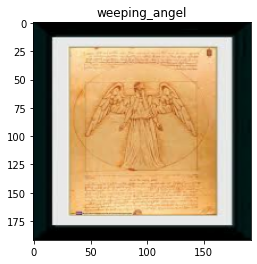

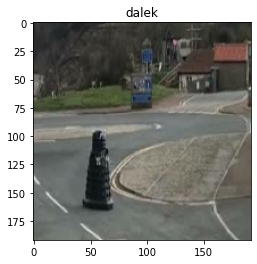

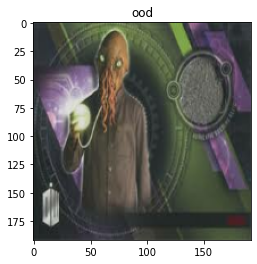

In [18]:
label_names = sorted(item.name for item in data_root.glob("*/") if item.is_dir())
for i, l in train_ds.take(3):
    plt.title(label_names[int(l[0])])
    plt.imshow(i[0] / 255.0)
    plt.grid(False)
    plt.show()


In [ ]:
mobile_net = keras.applications.MobileNetV2(
    input_shape=(192, 192, 3), include_top=False
)
mobile_net.trainable = False


In [ ]:
model = keras.Sequential(
    [
        # keras.layers.experimental.preprocess.*のレイヤーはTFjs実装がまだない?
        # keras.layers.Resizing(192, 192),
        # keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        # keras.layers.RandomFlip("horizontal"),
        mobile_net,
        keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(label_names), activation="softmax"),
    ]
)


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
steps_per_epoch = tf.math.ceil(len(tr_paths) / 32).numpy()
va_steps = tf.math.ceil(len(va_paths) / 32).numpy()

model_history = model.fit(
    train_ds,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_ds,
    validation_steps=va_steps,
)


In [ ]:
print(model_history.history.keys())
tr_loss = model_history.history["loss"]
va_loss = model_history.history["val_loss"]
tr_acc = model_history.history["accuracy"]
va_acc = model_history.history["val_accuracy"]

plt.figure()
plt.title("Accuracy")
plt.plot(tr_acc, "r")
plt.plot(va_acc, "bo")
plt.show()

plt.title("loss")
plt.plot(tr_loss, "r")
plt.plot(va_loss, "bo")
plt.show()


In [ ]:
# savedModel形式だとTFjsコンバート時に難アリ。よってKeras H5で
fname = f'/content/drive/MyDrive/Colab_Test/model.h5'
model.save(fname)

In [20]:
# モデルの読み込み
model = keras.models.load_model("../models/model.h5")
data_root = pathlib.Path("../../../Datasets/DWAliens/test")

all_paths_str, all_labels = mk_pathlist(data_root)
test_ds = mk_ds(all_paths_str, all_labels, test=True)
loss, acc = model.evaluate(test_ds)
print("test loss :", loss)
print("test  acc:", acc)


2/2 [==============================] - 1s 76ms/step - loss: 0.2857 - accuracy: 0.9214
test loss : 0.2856828272342682
test  acc: 0.9214285612106323
